# 3D-MOT Paper -- Statistical Analysis (ANOVA)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import pickle
import copy
import time
import re
import scipy.stats as stats
from tqdm import tqdm

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf, concatenate_raws
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

import collections
from autoreject import AutoReject

from joblib import Parallel, delayed

import scipy
import statsmodels as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.anova import AnovaRM

import sys

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#mne.viz.set_3d_backend('pyvistaqt')

In [4]:
#==================================================================
# General Variables
#==================================================================
# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD (~4 of them... and 4 blocks.)
# 32 - TBD (juste juste avant le 1, so I guess fin de trial, I have 88 of them... 4 trials)
trigger = 2

conds = ['1', '2', '3']
sides = ['right', 'left', 'classicmod']
perfs = ['good', 'bad']

# Making Custom Triggers and Event ID
# ------------------------------------
custom_trigger = dict()
custom_trigger['1'] = 100
custom_trigger['2'] = 200
custom_trigger['3'] = 300
custom_trigger['right'] = 10
custom_trigger['left'] = 20
custom_trigger['classicmod'] = 30
custom_trigger['good'] = 1
custom_trigger['bad'] = 2

# Making Event ID Dict to make it easy and readable to access (the desired) epochs.
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]
# ------------------------------------

# Channels & Clusters of Channels
# ------------------------------------
channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 
       'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
       'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 
       'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 
       'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

clusters_chs = dict()
clusters_chs['Frontal'] = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'Fpz', 
                       'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8']
clusters_chs['Central']  = ['C1', 'C3', 'C5', 'C2', 'C4', 'C6', 'Cz', 'CP5', 'CP3', 'CP1', 
                        'CPz', 'CP6', 'CP4', 'CP2', 'FC5', 'FC3', 'FC1', 'FC6', 'FC4', 'FC2']
clusters_chs['Temporal'] = ['FT7', 'T7', 'TP7', 'FT8', 'T8', 'TP8']
clusters_chs['Parietal'] = ['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
                        'POz', 'Pz', 'CPz', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4']
clusters_chs['Occipital'] = ['O1', 'Oz', 'POz','O2']
clusters_chs['All'] = channels

clusters_names = {'F':'Frontal', 'P':'Parietal', 'C':'Central', 'O':'Occipital', 'T':'Temporal', 'All':'All'}
# ------------------------------------

# 3D-MOT Phases Information
phases = ['ID', 'Tracking', 'Recall']
stimx = {'ID':0, 'Tracking':2, 'Recall':11}
time_windows = {'ID':(-.2,2), 'Tracking':(1.5, 11), 'Recall':(10.5, 18)}

# Epoch Information
epoch_length = 20
epoch_tmin = -3
baseline_corr = (-1, -0.2)

# Folders & Paths
# directory_src = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/src/'
# directory_data = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Data/'
# directory_preproc = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/data/'
directory_src = 'D:\\PhD\\NeuroTracker - Paper/src/'
#directory_data = 'D:\\PhD\\NeuroTracker - Paper/src/'
directory_preproc = 'D:\\PhD\\NeuroTracker - Paper/data/'


# STATS - FREQUENCY

 ## 1. Prep Stats Structures (DF)

In [3]:
stats_time_windows = {'id':(0.3, 1.3), 'tracking':(5, 6), 'recall':(11.3, 12.3)}
stats_freq_bands = {'delta':(0, 3), 'theta':(4, 7), 'alpha':(8, 12), 'beta':(13, 30), 'gamma':(31, 45)}

allfiles = list(glob.iglob(directory_preproc + 'ERSP_1-50Hz/Subject_*_ersp.pkl'))
participants_list = [re.search('Subject_(.*)_ersp', curfile).group(1) for curfile in allfiles]

stats_nb_participants = len(participants_list)
stats_phases = ['id', 'tracking', 'recall']
stats_setsizes = ['1', '2', '3']
stats_fbands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
stats_clusters = list(clusters_chs.keys())
stats_values_per_participant = len(stats_phases) * len(stats_setsizes) * len(stats_fbands) * len(stats_clusters)
stats_total_rows = stats_nb_participants * stats_values_per_participant

df = pd.DataFrame({'Phase': np.repeat(stats_phases, len(stats_setsizes) * len(stats_fbands) * len(stats_clusters) * stats_nb_participants),
                   'SetSize': np.tile(np.repeat(stats_setsizes, len(stats_fbands) * len(stats_clusters) * stats_nb_participants), len(stats_phases)),
                   'FBand': np.tile(np.repeat(stats_fbands, len(stats_clusters) * stats_nb_participants), len(stats_setsizes) * len(stats_phases)),
                   'Cluster': np.tile(np.repeat(stats_clusters, stats_nb_participants), len(stats_setsizes) * len(stats_phases) * len(stats_fbands)),
                   'Participant': np.tile(participants_list, stats_values_per_participant),
                   'Power': np.zeros(stats_total_rows)})

## 2. Fill DF with Individual (Participant's mean) Power

In [4]:
# Load Power Files 1 by 1
for filepath in glob.iglob(directory_preproc + 'ERSP_1-50Hz/Subject_*_ersp.pkl'):
    filename = filepath[filepath.rfind('/')+1:]
    print(f'Loading: {filename}...')

    with open(filepath, "rb") as f:
        power = pickle.load(f)

    times = power.times
    # TODO: Test as ratio and absolute values...
    # power = power.apply_baseline((-1,0), mode='ratio', verbose=False)

    participant = re.search('Subject_(.*)_ersp', filename).group(1)

    nb_iterations = stats_values_per_participant
    cur_iteration = 0

    pbar = tqdm(total=nb_iterations)
    for setsize in stats_setsizes:
        power_ss = power[setsize + '/good']
        for cluster in clusters_chs.keys():
            power_ss_cl = power_ss.copy().pick_channels(clusters_chs[cluster])
            for phase in stats_phases:
                time_window = stats_time_windows[phase]
                for fband in stats_fbands:
                    fband_limits = stats_freq_bands[fband]

                    # Get Power for specific window with conditions.
                    cur_power = np.mean(power_ss_cl.data[:,:, fband_limits[0]:fband_limits[1], (times >= time_window[0]) & (times <= time_window[1])])

                    # Add Power Value to Stats DF.       
                    df.loc[(df['SetSize']==setsize) & (df['Phase']==phase) & (df['FBand']==fband) & (df['Participant']==participant) & (df['Cluster']==cluster), 'Power'] = cur_power

                    pbar.update(1)

    del power
    pbar.close()

df.to_csv('3D-MOT_stats_tfr-rawpower-1s.csv')

Loading: ERSP_1-50Hz\Subject_F12F2_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:31<00:00,  8.66it/s]


Loading: ERSP_1-50Hz\Subject_F12M1_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:46<00:00,  5.79it/s]


Loading: ERSP_1-50Hz\Subject_F19M1_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:40<00:00,  6.71it/s]


Loading: ERSP_1-50Hz\Subject_F26F2_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:22<00:00, 12.24it/s]


Loading: ERSP_1-50Hz\Subject_F5M1_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:14<00:00, 18.36it/s]


Loading: ERSP_1-50Hz\Subject_M22F2_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:40<00:00,  6.66it/s]


Loading: ERSP_1-50Hz\Subject_M8M1_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:43<00:00,  6.14it/s]


Loading: ERSP_1-50Hz\Subject_M8M2_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:48<00:00,  5.56it/s]


Loading: ERSP_1-50Hz\Subject_S20M1_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:50<00:00,  5.35it/s]


Loading: ERSP_1-50Hz\Subject_S21F1_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:56<00:00,  4.79it/s]


Loading: ERSP_1-50Hz\Subject_T11F1_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:37<00:00,  7.13it/s]


Loading: ERSP_1-50Hz\Subject_T16F2_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:54<00:00,  4.99it/s]


Loading: ERSP_1-50Hz\Subject_T18F2_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:21<00:00, 12.58it/s]


Loading: ERSP_1-50Hz\Subject_T18M1_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:58<00:00,  4.65it/s]


Loading: ERSP_1-50Hz\Subject_T23F1_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:44<00:00,  6.10it/s]


Loading: ERSP_1-50Hz\Subject_T23F2_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:52<00:00,  5.19it/s]


Loading: ERSP_1-50Hz\Subject_T25F1_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:46<00:00,  5.78it/s]


Loading: ERSP_1-50Hz\Subject_T9F2_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:36<00:00,  7.43it/s]


Loading: ERSP_1-50Hz\Subject_W10F2_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:46<00:00,  5.75it/s]


Loading: ERSP_1-50Hz\Subject_W17M2_ersp.pkl...


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:52<00:00,  5.16it/s]


In [35]:
#df = pd.read_csv('3D-MOT_stats_tfr.csv')
#df = pd.read_csv('3D-MOT_stats_tfr-blratio-500ms.csv')
df = pd.read_csv('3D-MOT_stats_tfr-rawpower-1s.csv')

## Explore / Look at the Data

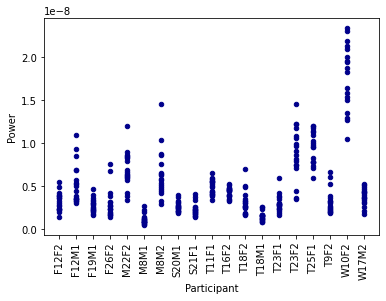

In [9]:
# Participant F5M1 - very high power, outlier...
df2 = df.drop(df[df.Participant == 'F5M1'].index)

#df2 = df

ax1 = df2[(df2['Phase'] == 'id') & (df2['FBand'] == 'alpha')].plot.scatter(x='Participant', y='Power', c='DarkBlue')
tmp = plt.xticks(rotation=90)
plt.show()

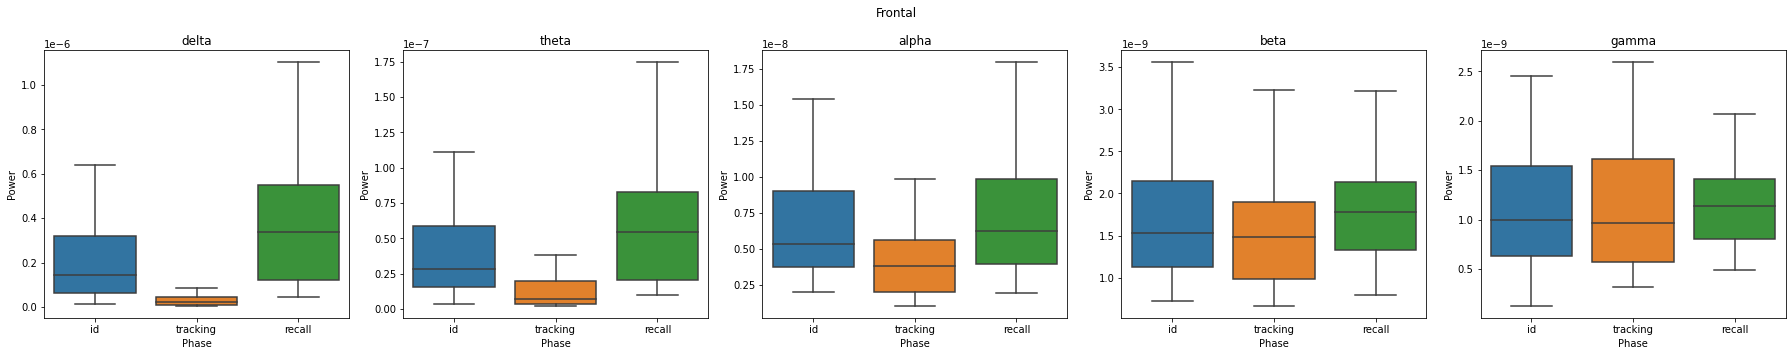

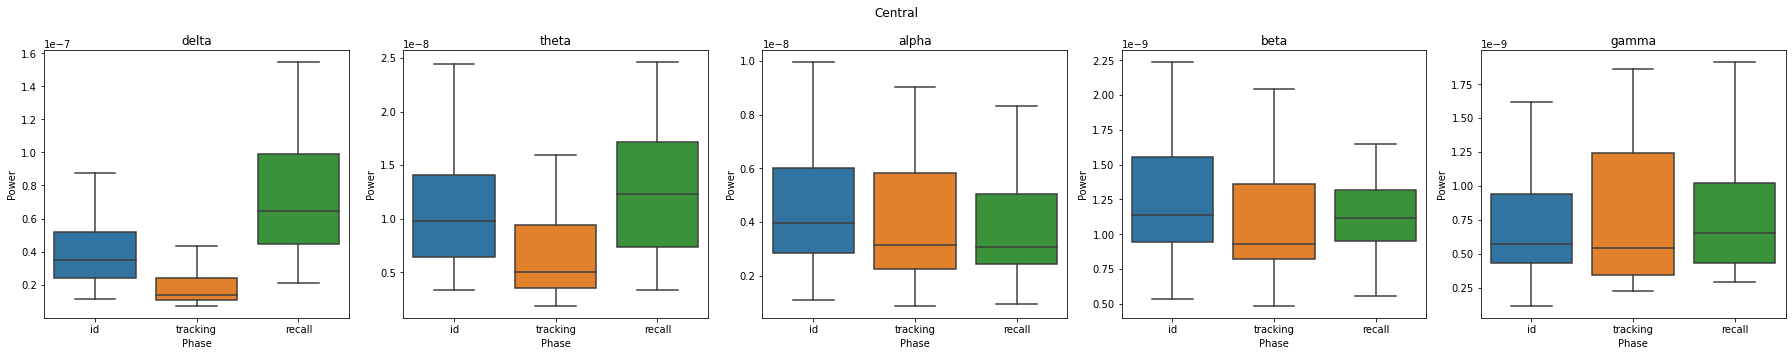

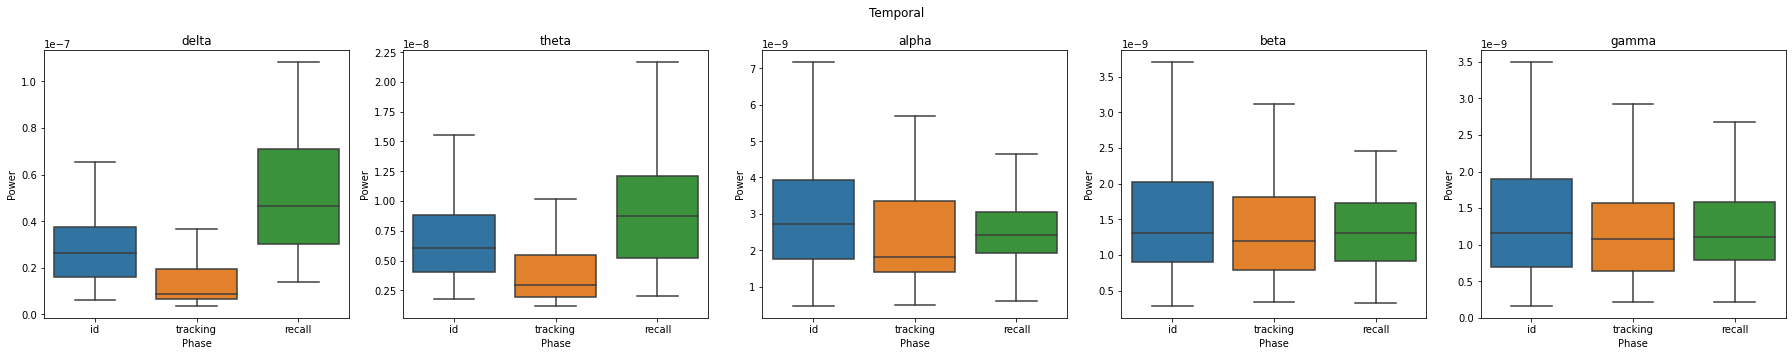

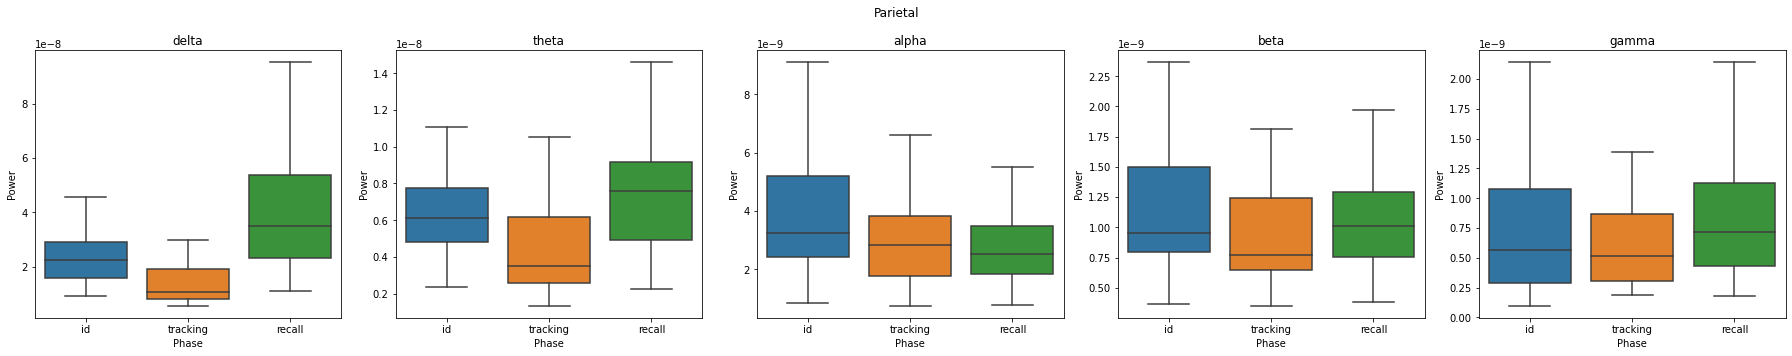

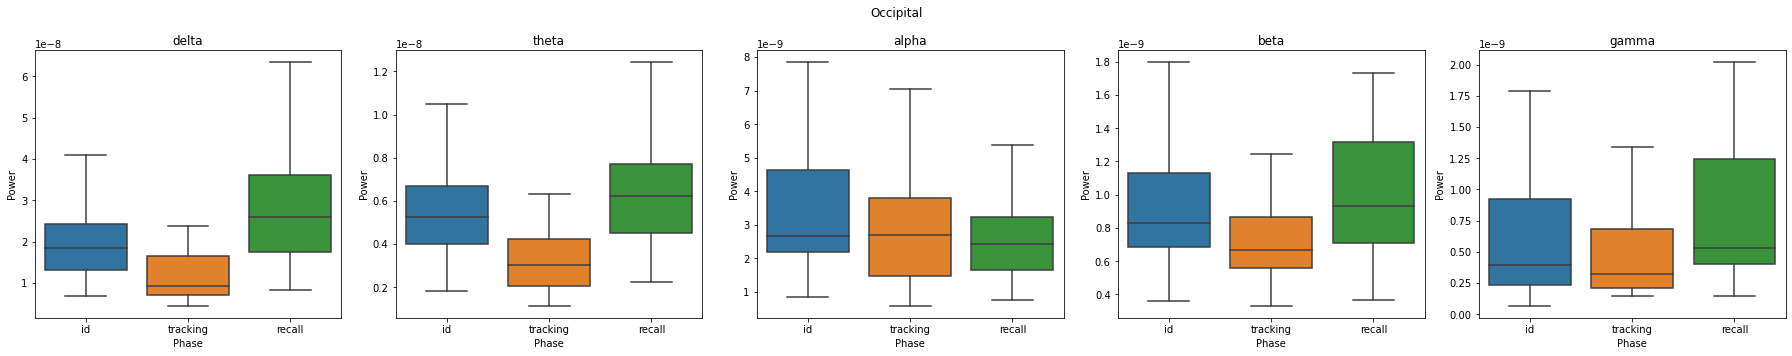

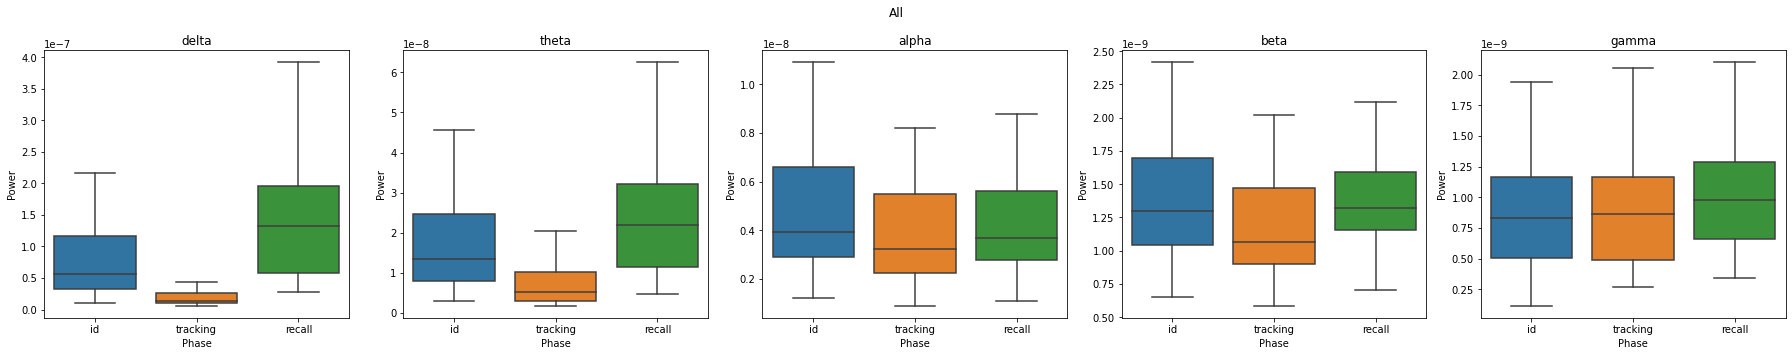

In [10]:
for cl in stats_clusters:
    fig, ax = plt.subplots(1, 5, figsize=(25, 5))
    fig.suptitle(cl)
    for i, cur_band in enumerate(stats_fbands):
        df3 = df2[(df2['FBand'] == cur_band) & (df2['Cluster'] == cl)]
        sns.boxplot(x="Phase", y="Power", data=df3, showfliers=False, ax=ax[i])
        ax[i].set_title(cur_band)

    plt.tight_layout()
    plt.show()

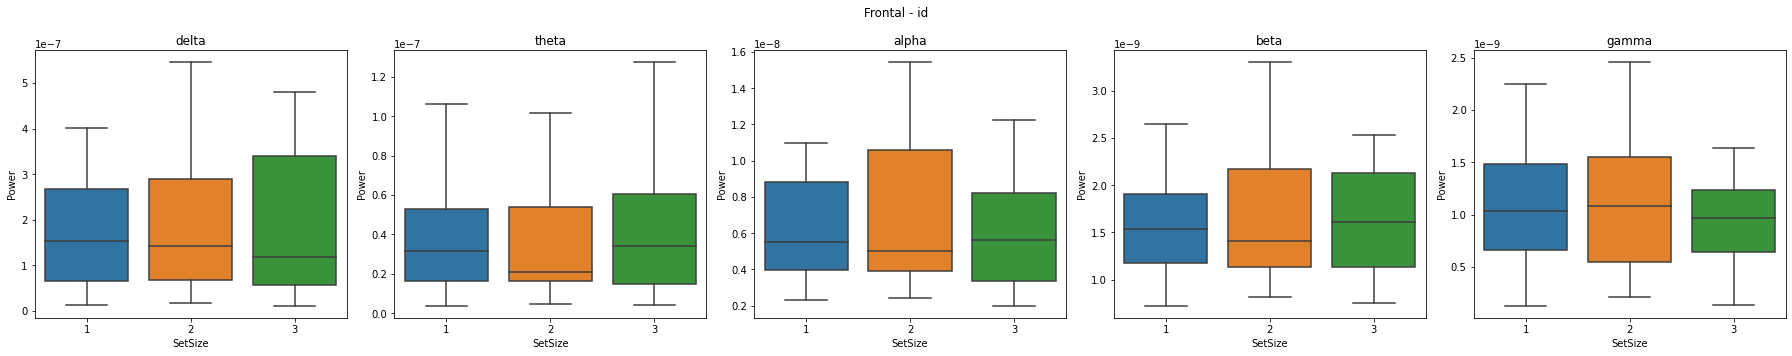

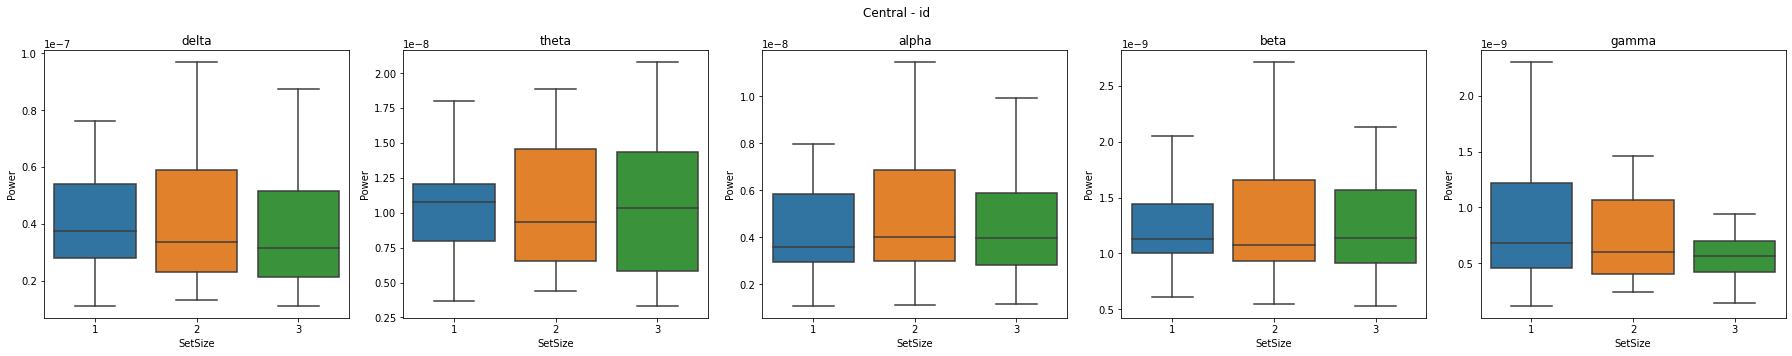

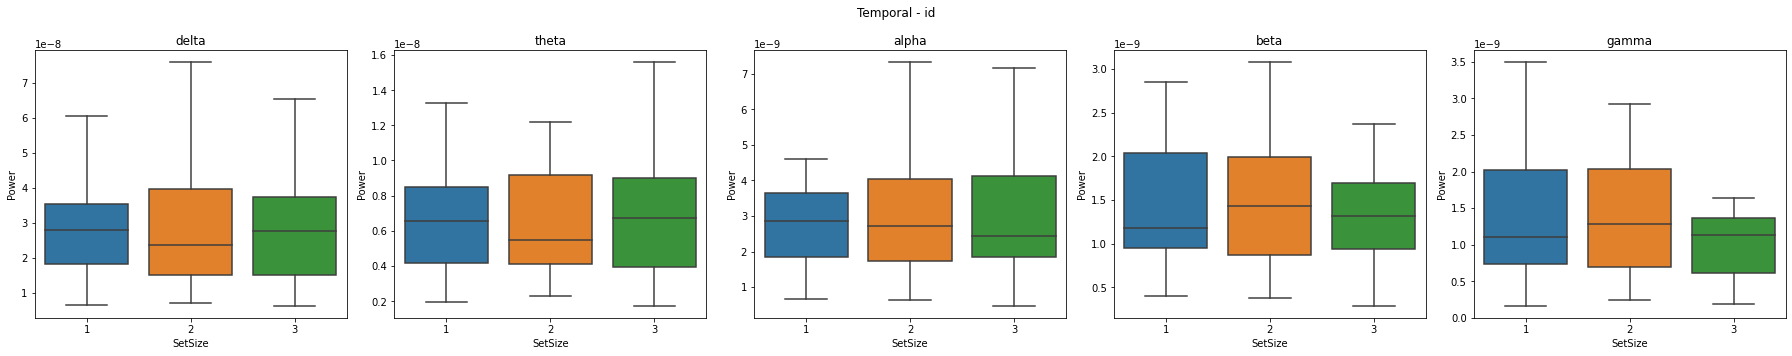

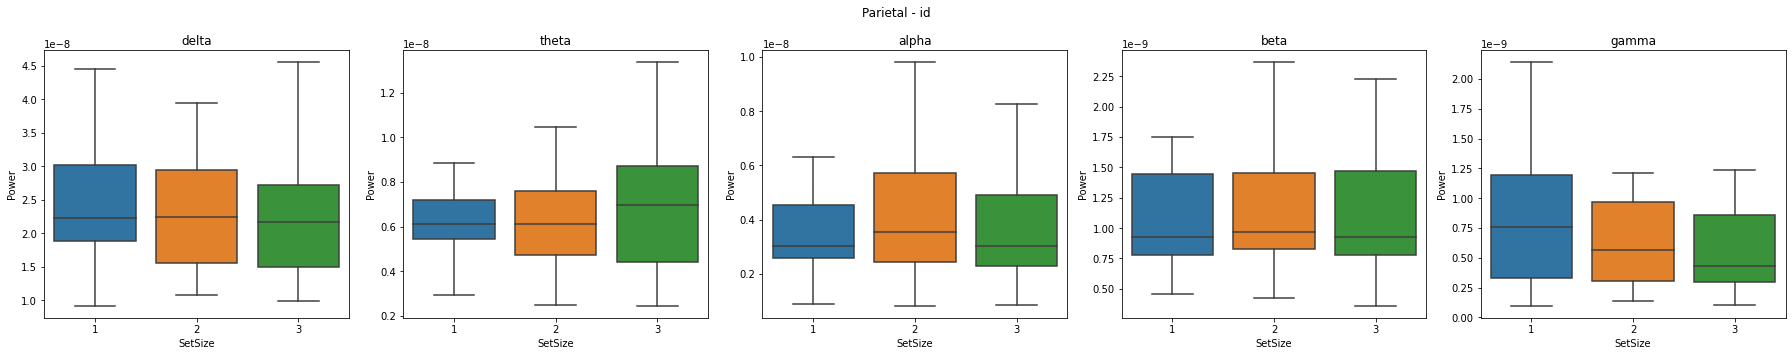

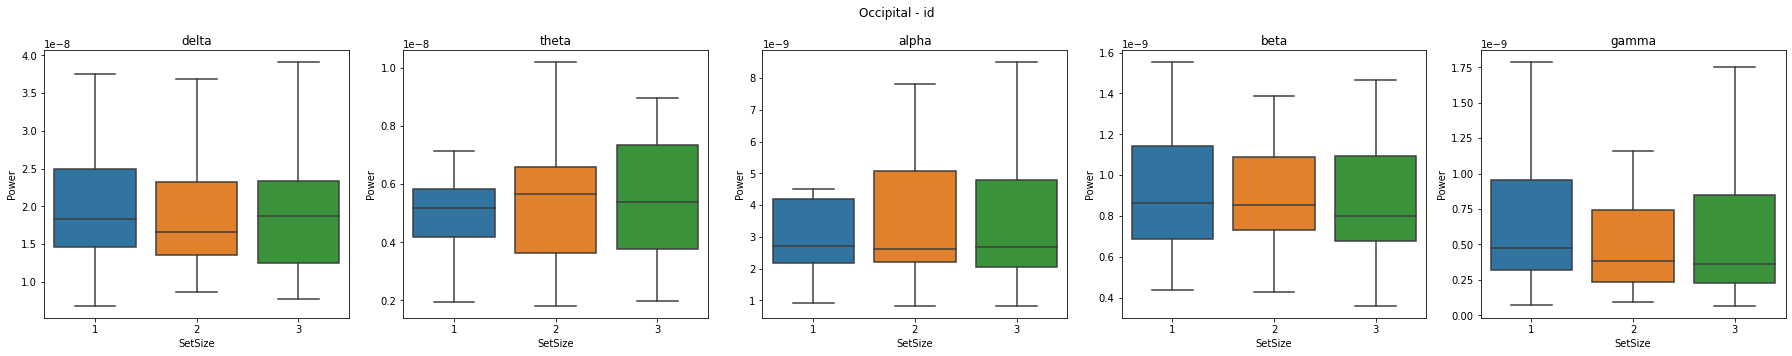

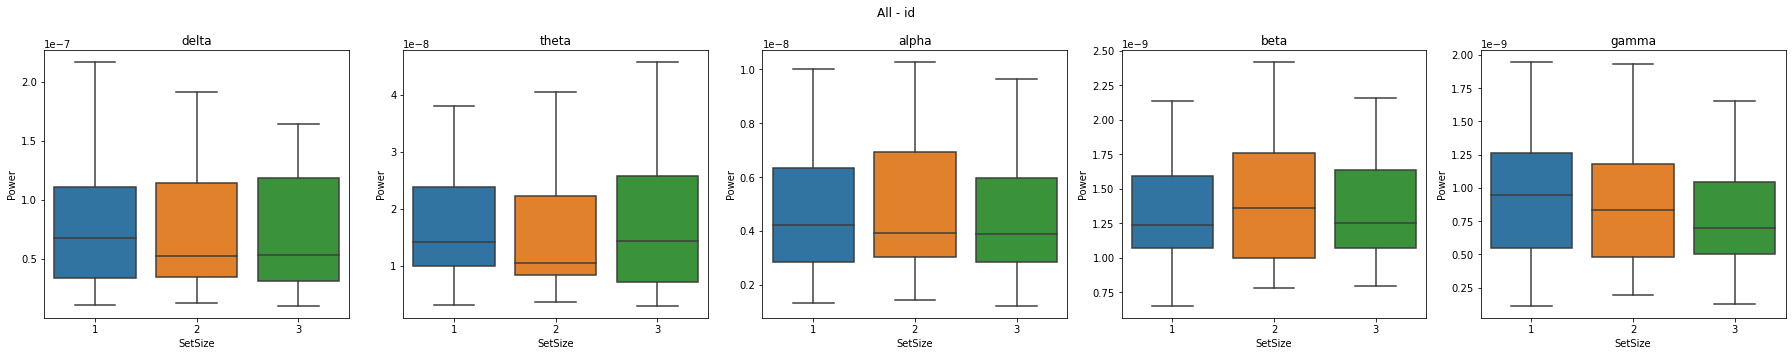

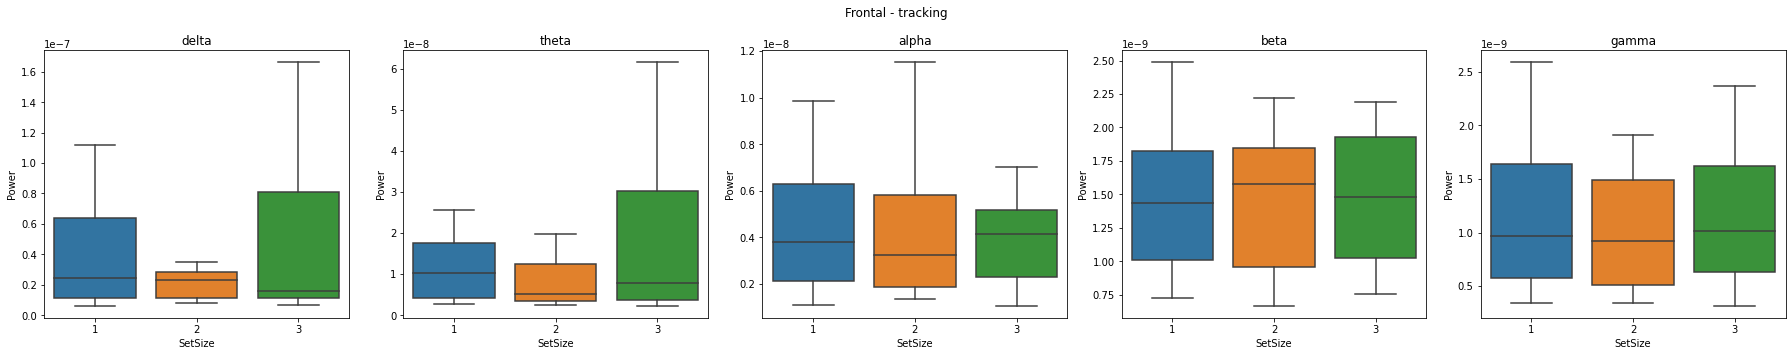

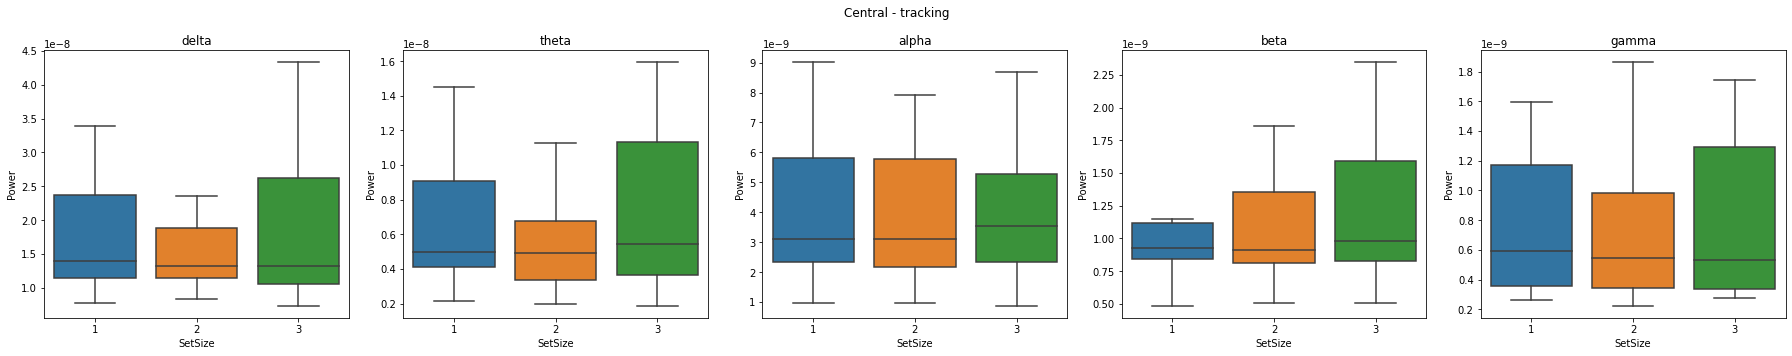

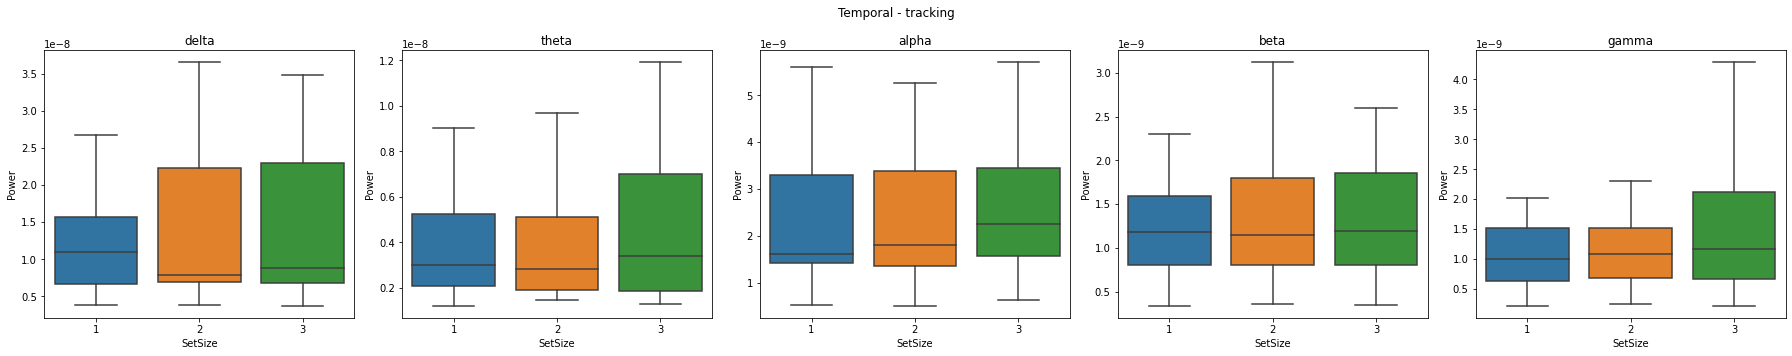

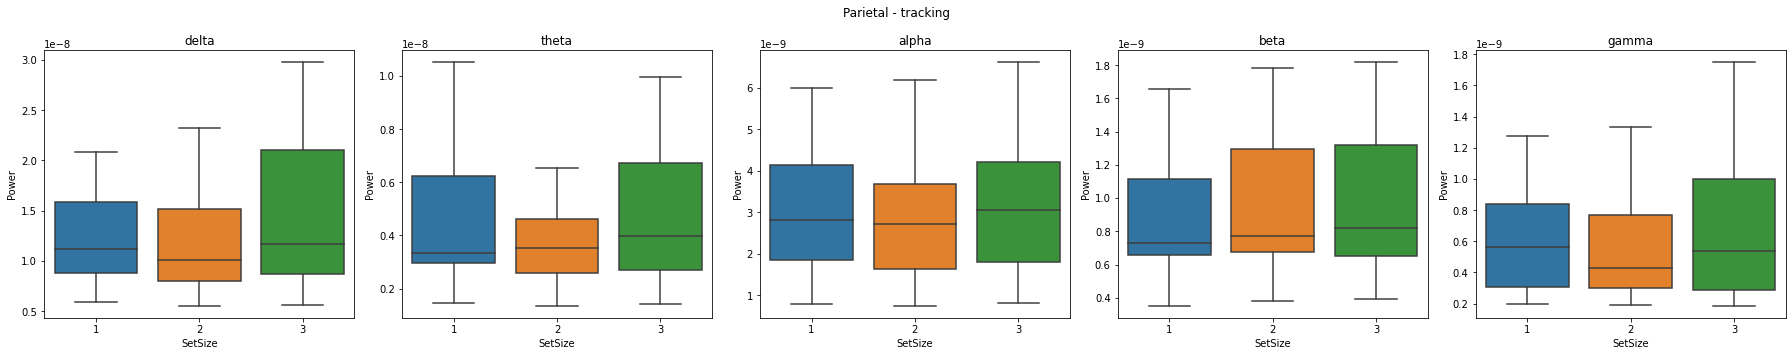

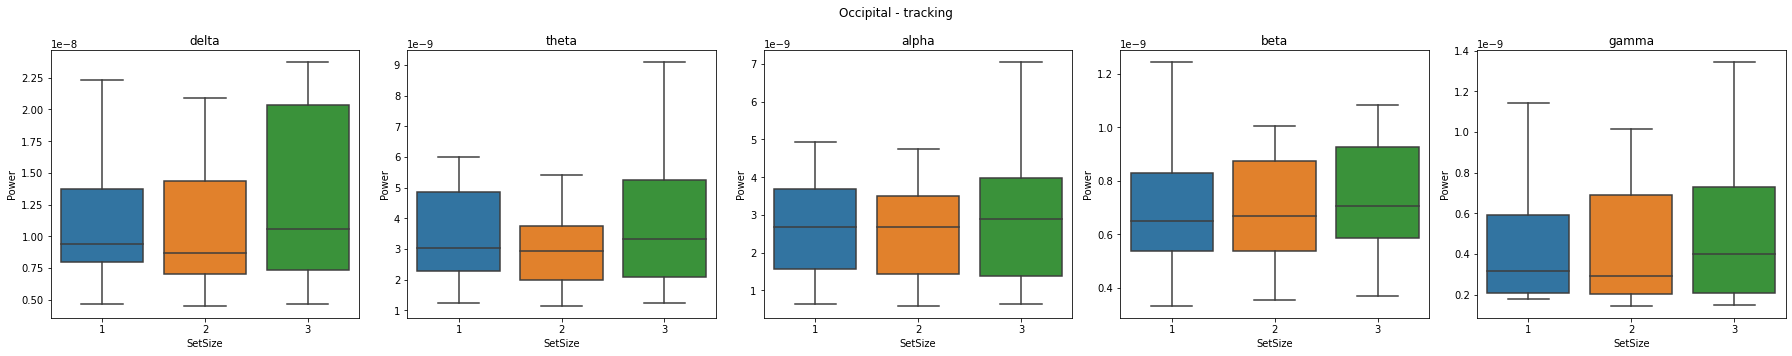

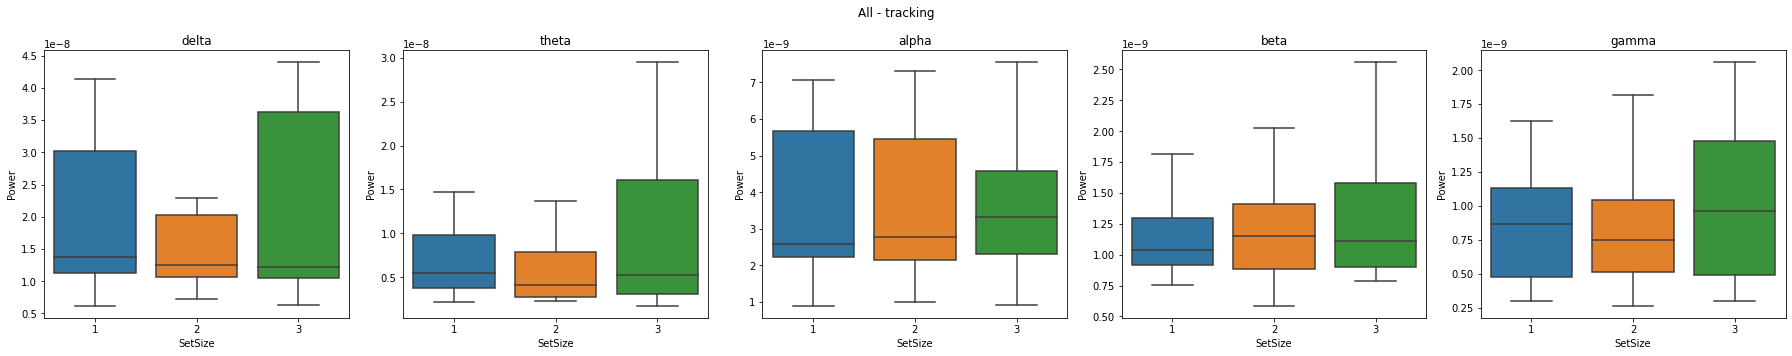

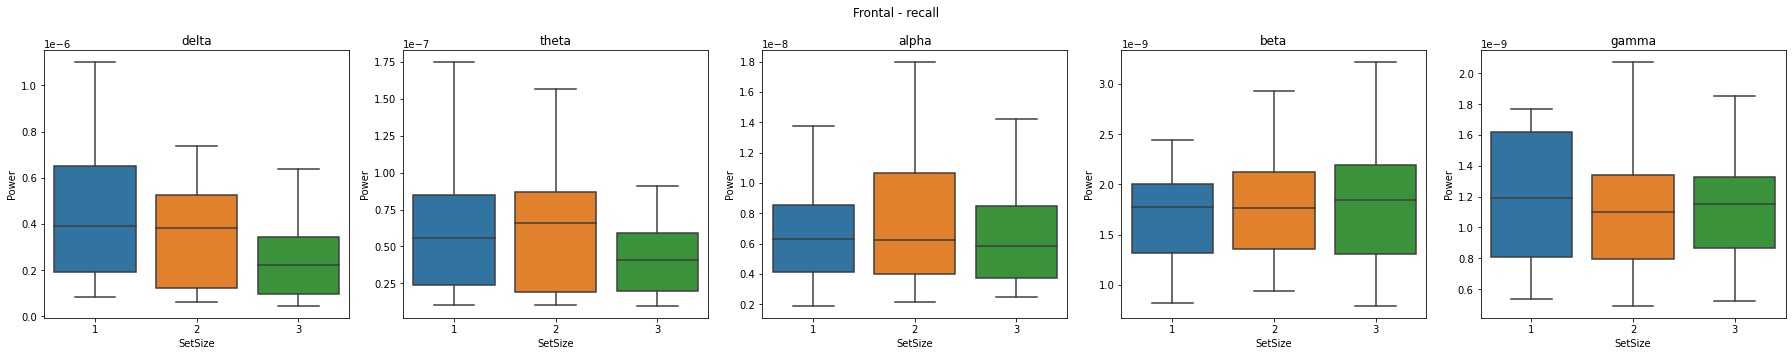

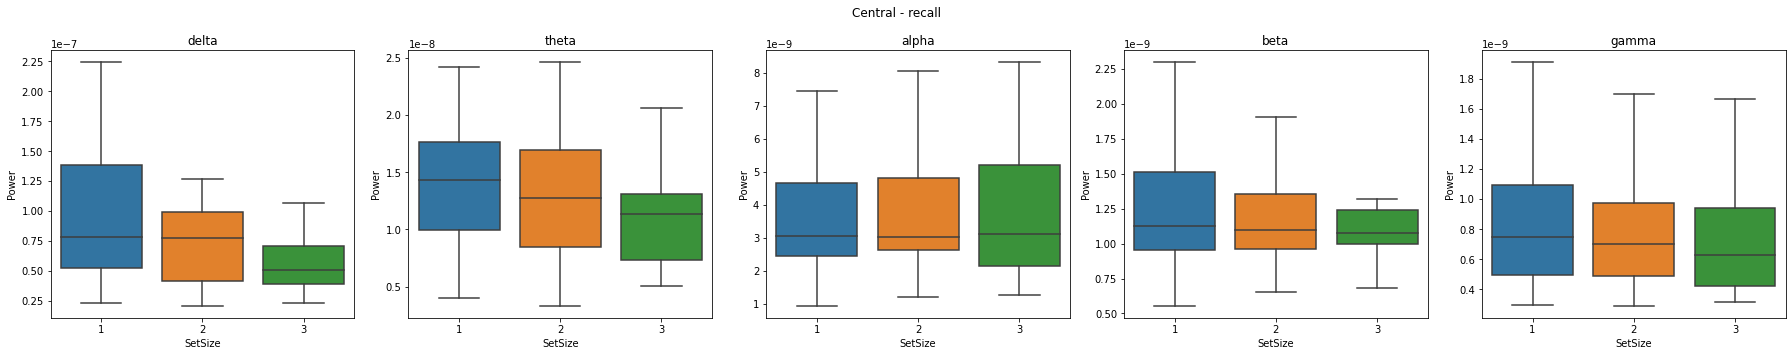

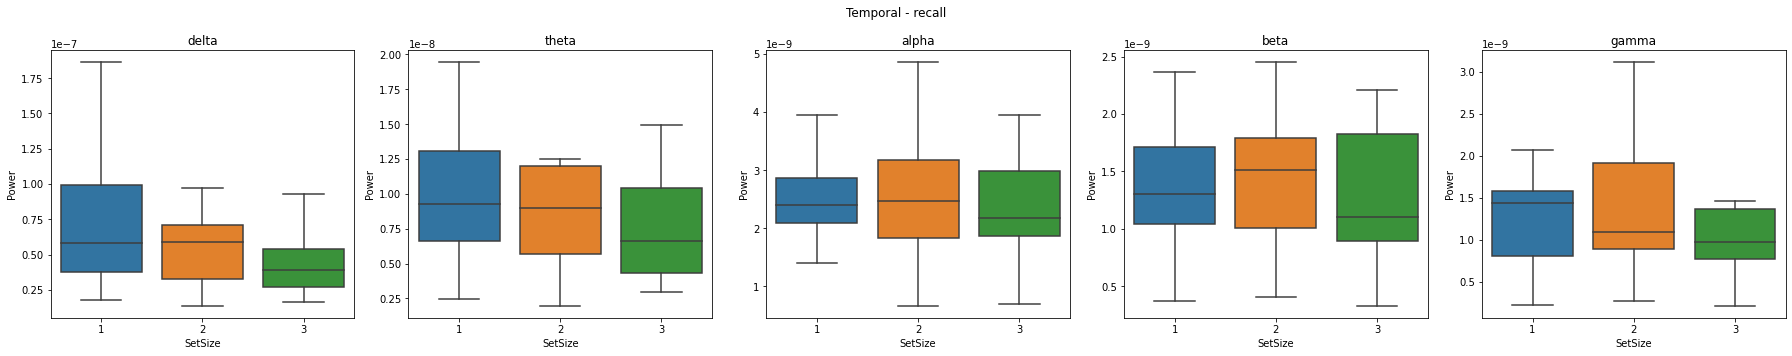

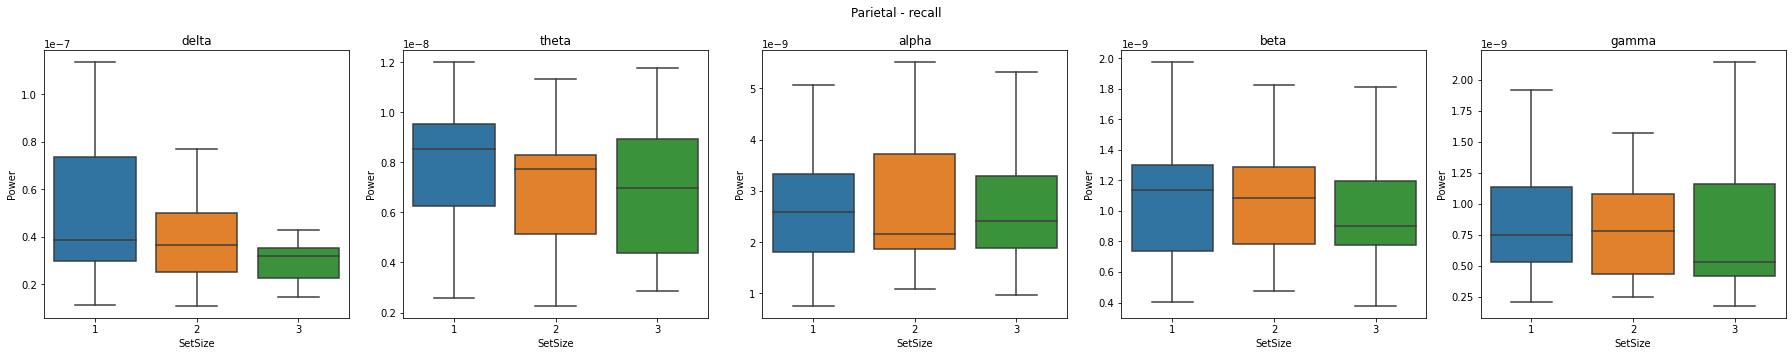

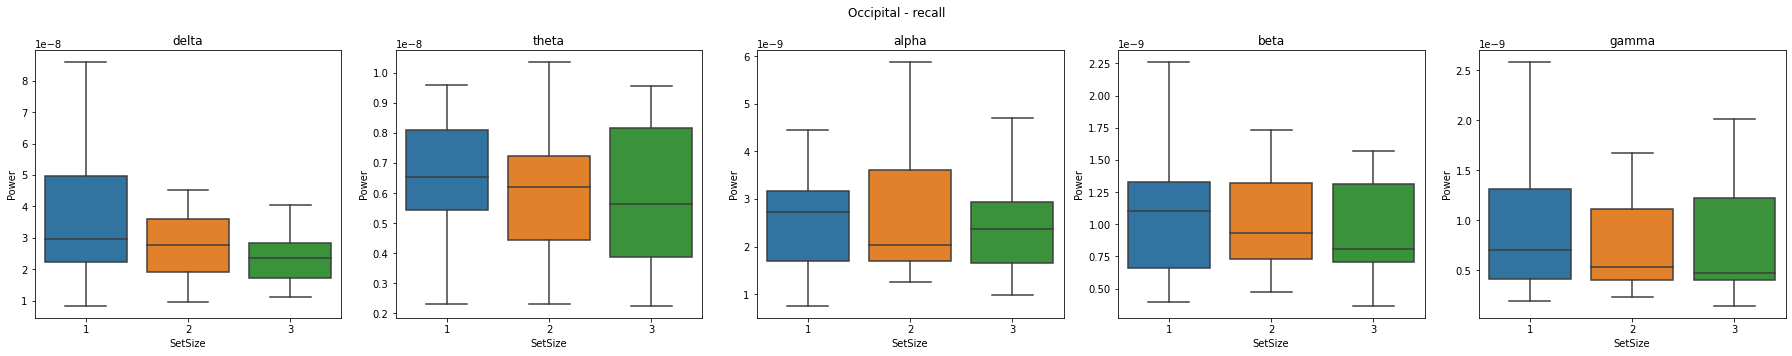

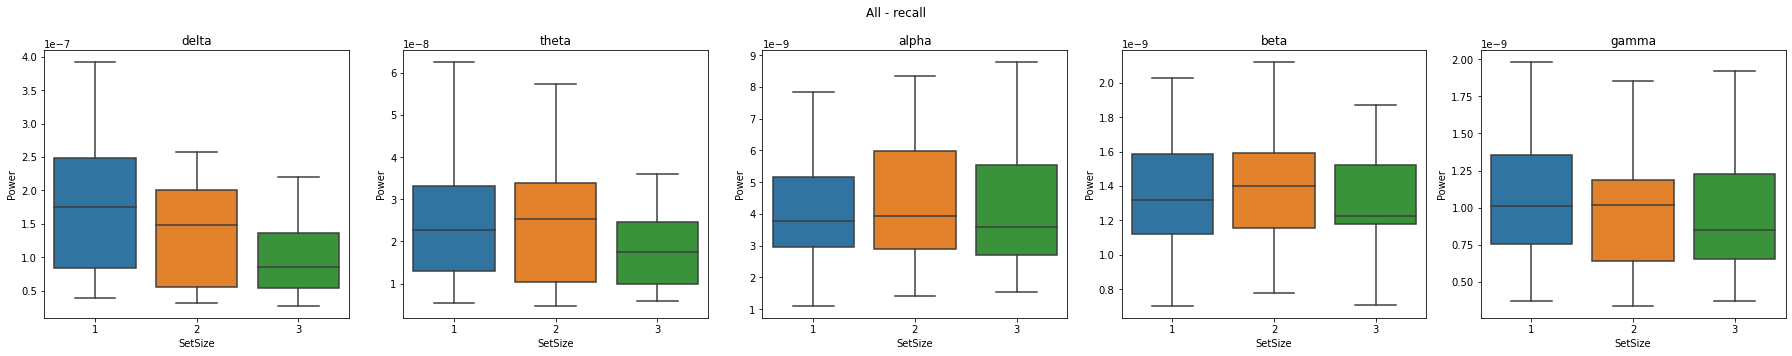

In [11]:
for phase in stats_phases:
    for cl in stats_clusters:
        fig, ax = plt.subplots(1, 5, figsize=(25, 5))
        fig.suptitle(f'{cl} - {phase}')       
        for i, cur_band in enumerate(stats_fbands):
            df3 = df2[(df2['FBand'] == cur_band) & (df2['Cluster'] == cl) & (df2['Phase'] == phase)]
            sns.boxplot(x="SetSize", y="Power", data=df3, showfliers=False, ax=ax[i])
            ax[i].set_title(cur_band)

        plt.tight_layout()
        plt.show()

In [12]:
df2 = df2.drop(df2[df2.Cluster == 'All'].index)

aovrm = AnovaRM(df2, 'Power', 'Participant', within=['SetSize', 'Phase', 'FBand'], aggregate_func='mean')
resaov = aovrm.fit()

print(resaov)

                       Anova
                    F Value  Num DF  Den DF  Pr > F
---------------------------------------------------
SetSize              4.6017  2.0000  36.0000 0.0166
Phase               12.2299  2.0000  36.0000 0.0001
FBand               50.3896  4.0000  72.0000 0.0000
SetSize:Phase        6.3554  4.0000  72.0000 0.0002
SetSize:FBand        5.2364  8.0000 144.0000 0.0000
Phase:FBand         11.5828  8.0000 144.0000 0.0000
SetSize:Phase:FBand  6.7109 16.0000 288.0000 0.0000



In [14]:
df = pd.read_csv('3D-MOT_stats_tfr-blratio-1s.csv')

aovrm = AnovaRM(df, 'Power', 'Participant', within=['SetSize', 'Phase', 'FBand'], aggregate_func='mean')
resaov = aovrm.fit()

print(resaov)

                       Anova
                    F Value  Num DF  Den DF  Pr > F
---------------------------------------------------
SetSize              2.9201  2.0000  38.0000 0.0661
Phase                7.2922  2.0000  38.0000 0.0021
FBand               11.8032  4.0000  76.0000 0.0000
SetSize:Phase        2.4641  4.0000  76.0000 0.0521
SetSize:FBand        4.5853  8.0000 152.0000 0.0001
Phase:FBand          6.5405  8.0000 152.0000 0.0000
SetSize:Phase:FBand  2.8775 16.0000 304.0000 0.0002



## Tukey is not the right post hoc test here.
## Do paired t-test with m.comparison

In [47]:
mc = MultiComparison(df2['Power'], df2['Phase'])
mcresult = mc.tukeyhsd(0.05)
mcresult.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
id,recall,1.7854,0.0,1.288,2.2829,True
id,tracking,-0.7951,0.0005,-1.2925,-0.2976,True
recall,tracking,-2.5805,0.0,-3.078,-2.0831,True


In [26]:
# -------------------- ID -------------------- 
df3 = df2[(df2['Phase'] == 'id')]# & (df2['FBand'] == 'delta')]

mc = MultiComparison(df3['Power'], df3['SetSize'])
mcresult = mc.tukeyhsd(0.05)
print(mcresult.summary())

# -------------------- Tracking -------------------- 
df3 = df2[(df2['Phase'] == 'tracking')]# & (df2['FBand'] == 'delta')]

mc = MultiComparison(df3['Power'], df3['SetSize'])
mcresult = mc.tukeyhsd(0.05)
print(mcresult.summary())

# -------------------- Recall -------------------- 
df3 = df2[(df2['Phase'] == 'recall')]# & (df2['FBand'] == 'delta')]

mc = MultiComparison(df3['Power'], df3['SetSize'])
mcresult = mc.tukeyhsd(0.05)
print(mcresult.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.2032 0.7816 -0.9159 0.5095  False
     1      3  -0.2174 0.7543 -0.9301 0.4953  False
     2      3  -0.0142 0.9988 -0.7269 0.6985  False
---------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.0884 0.5087 -0.2753 0.0986  False
     1      3   0.1328 0.2184 -0.0541 0.3198  False
     2      3   0.2212 0.0154  0.0342 0.4082   True
---------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -1.4711 0.0207 -2.7616 -0.1806   True
     1      3  -2.5666    0.0  -3.857 -1.2761   True
     2 

# STATS - TIME DOMAIN

## Occipital ERPs - Stats

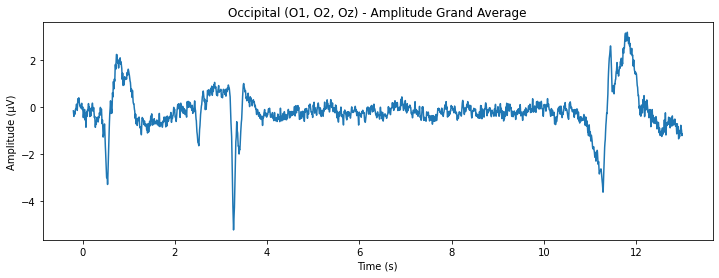

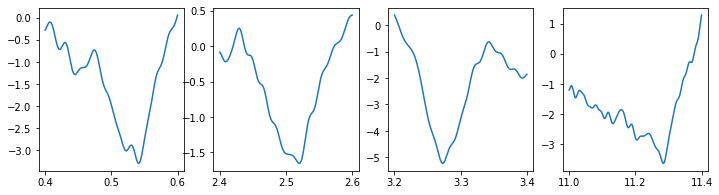

In [26]:
with open(directory_preproc + 'ERPs/Occipital_ERPs.pkl',"rb") as f:
    data_pickle = pickle.load(f)
    
data_dict = data_pickle['data_dict']
times = data_pickle['times']

fig = plt.figure(figsize=(12,4))
data_all = []
for participant in data_dict.keys():
    if participant == 'Subject_F5M1_cleanAR.pkl':
        continue
    data_all.append(data_dict[participant])
data_all = np.stack(data_all)
data_all_mean = np.mean(data_all, 0)

times_window = (times > -0.2) & (times <= 13)
plt.plot(times[times_window], data_all_mean[times_window] * 1e6)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.title('Occipital (O1, O2, Oz) - Amplitude Grand Average')
plt.show()

fig, axs = plt.subplots(1,4, figsize=(12, 3))

times_windows = dict()
times_windows['t0'] = (times > 0.4) & (times <= 0.6)
times_windows['t2'] = (times > 2.4) & (times <= 2.6)
times_windows['t3'] = (times > 3.2) & (times <= 3.4)
times_windows['t11'] = (times > 11) & (times <= 11.4)

axs[0].plot(times[times_windows['t0']], data_all_mean[times_windows['t0']] * 1e6)
axs[1].plot(times[times_windows['t2']], data_all_mean[times_windows['t2']] * 1e6)
axs[2].plot(times[times_windows['t3']], data_all_mean[times_windows['t3']] * 1e6)
axs[3].plot(times[times_windows['t11']], data_all_mean[times_windows['t11']] * 1e6)

plt.show()

In [88]:
erp_amplitudes = dict()

erp_amplitudes['t0'] = np.min(data_all[:, times_windows['t0']] * 1e6, 1)
erp_amplitudes['t2'] = np.min(data_all[:, times_windows['t2']] * 1e6, 1)
erp_amplitudes['t3'] = np.min(data_all[:, times_windows['t3']] * 1e6, 1)
erp_amplitudes['t11'] = np.min(data_all[:, times_windows['t11']] * 1e6, 1)

df_erp_wide = pd.DataFrame(erp_amplitudes)
df_erp_wide.head()

,t0,t2,t3,t11
0,-4.419642,-3.591515,-7.546704,-7.028523
1,-5.293307,-2.303087,-5.735177,-4.639202
2,-3.472011,-0.448364,-4.447711,-3.635637
3,-7.908233,-4.085121,-8.523738,-5.071880
4,-6.291991,-3.275236,-7.018365,-8.272263


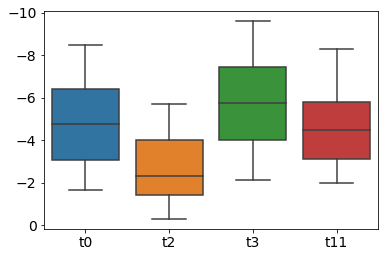

In [89]:
sns.boxplot(data=df_erp_wide, showfliers=False)
plt.gca().invert_yaxis()
plt.show()

In [90]:
df_erp_wide['id'] = range(len(df_erp_wide))
df_erp_long = pd.wide_to_long(df_erp_wide, 't', i='id', j='time')
df_erp_long = df_erp_long.reset_index(level=['time', 'id'])
print(df_erp_long)

    id  time         t
0    0     0 -4.419642
1    1     0 -5.293307
2    2     0 -3.472011
3    3     0 -7.908233
4    4     0 -6.291991
..  ..   ...       ...
71  14    11 -6.780164
72  15    11 -3.914657
73  16    11 -4.122512
74  17    11 -5.938088
75  18    11 -3.035611

[76 rows x 3 columns]


In [91]:
aovrm = AnovaRM(df_erp_long, 't', 'id', within=['time'], aggregate_func='mean')
resaov = aovrm.fit()

print(resaov)

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
time 23.3502 3.0000 54.0000 0.0000



In [92]:

print(scipy.stats.ttest_rel(df_erp_wide['t0'], df_erp_wide['t2'])) # Should be significant
print(scipy.stats.ttest_rel(df_erp_wide['t0'], df_erp_wide['t11'])) # Should not be significant

Ttest_relResult(statistic=-7.019619025997056, pvalue=1.496316498244438e-06)
Ttest_relResult(statistic=-0.6178943446954868, pvalue=0.5443842578218268)


## CDA - Set Sizes

Skipping...F26F2.bdf-3-right
Skipping...F5M1.bdf-3-left


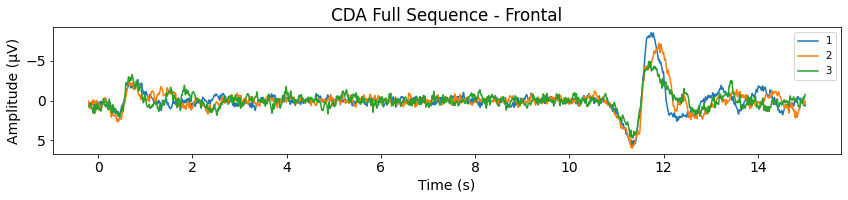

In [149]:
with open(directory_preproc + 'CDA/CDA_data_raw.pkl',"rb") as f:
    data_pickle = pickle.load(f)

CDA_ss_all = data_pickle['CDA_ss_all']
times = data_pickle['times']

times_window = (times >= -0.2) & (times <= 15)

plt.rcParams.update({'font.size':14})
fig = plt.figure(figsize=(12, 3))

for size in conds:
    cda = []
    for participant in CDA_ss_all.keys():
        #if participant == 'F26F2.bdf' or participant == 'F5M1.bdf':
            #continue
        try:
            cda.append(CDA_ss_all[participant]['Frontal'][size]['left'])
        except:
            print(f'Skipping...{participant}-{size}-left')
        try:
            cda.append(CDA_ss_all[participant]['Frontal'][size]['right'])
        except:
            print(f'Skipping...{participant}-{size}-right')

    cda = np.stack(cda)
    cda_mean = np.mean(cda, 0)

    plt.plot(times[times_window], cda_mean[times_window] * 1e6, label=size)

plt.rcParams.update({'font.size':10})
plt.legend()
plt.rcParams.update({'font.size':14})
plt.title(f'CDA Full Sequence - Frontal')
plt.ylabel('Amplitude (μV)')
plt.xlabel('Time (s)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [495]:
# Best Results with ID3 - Min, Recall2 - Mean
#stats_time_windows = {'id':(0.5, 1), 'id2':(0.5, 1.5), 'id3':(0.5, 2), 'rec':(11.5, 12), 'rec2':(11.5, 12.5), 'rec3':(11.5, 13)}
stats_time_windows = {'id':(0.5, 1.5), 'tracking':(5,6), 'recall':(11.5, 12.5)}

# Missing Good Trials for ss=3, to keep pairwise comp, remove from stats.
participants_list = [participant for participant in CDA_ss_all.keys() if participant != 'F5M1.bdf' and participant != 'F26F2.bdf']

stats_nb_participants = len(participants_list)
stats_phases = list(stats_time_windows.keys()) #['id', 'recall']
stats_setsizes = ['1', '2', '3']
stats_clusters = [cluster for cluster in clusters_chs.keys() if cluster != 'All']
stats_values_per_participant = len(stats_phases) * len(stats_setsizes) * len(stats_clusters)
stats_total_rows = stats_nb_participants * stats_values_per_participant

df_cda = pd.DataFrame({'Phase': np.repeat(stats_phases, len(stats_setsizes) * len(stats_clusters) * stats_nb_participants), 
                    'SetSize': np.tile(np.repeat(stats_setsizes, len(stats_clusters) * stats_nb_participants), len(stats_phases)),
                    'Cluster': np.tile(np.repeat(stats_clusters, stats_nb_participants), len(stats_phases) * len(stats_setsizes)),
                    'Participant': np.tile(participants_list, stats_values_per_participant),
                    'Mean': np.zeros(stats_total_rows),
                    'Min': np.zeros(stats_total_rows)})

In [496]:
# TODO: Retry with side? Perhaps there is an effect! (as seen on lateralized activity)
for phase in stats_phases:
    for setsize in stats_setsizes:
        for cluster in stats_clusters:
            cda_left = None
            cda_right = None
            for participant in participant_list:
                if participant == 'F26F2.bdf' or participant == 'F5M1.bdf':
                    continue
                try:
                    cda_left = CDA_ss_all[participant][cluster][setsize]['left']
                except:
                    print(f'Skipping...{participant}-{cluster}-{setsize}-left')
                try:
                    cda_right = CDA_ss_all[participant][cluster][setsize]['right']
                except:
                    print(f'Skipping...{participant}-{cluster}-{setsize}-right')

                if cda_left is not None and cda_right is not None:
                    cur_cda = ((cda_right + cda_left)/2) * 1e6
                    cur_cda = cur_cda[(times >= stats_time_windows[phase][0]) & (times <= stats_time_windows[phase][1])]
                    cur_mean = np.mean(cur_cda)
                    cur_min = np.min(cur_cda)

                    # Add CDA Amplitude to Stats DF.       
                    df_cda.loc[(df_cda['SetSize']==setsize) & (df_cda['Phase']==phase) & (df_cda['Participant']==participant) & (df_cda['Cluster']==cluster), 'Mean'] = cur_mean
                    df_cda.loc[(df_cda['SetSize']==setsize) & (df_cda['Phase']==phase) & (df_cda['Participant']==participant) & (df_cda['Cluster']==cluster), 'Min'] = cur_min

df_cda[df_cda['Mean'] == 0]

,Phase,SetSize,Cluster,Participant,Mean,Min


======================= Mean =====================


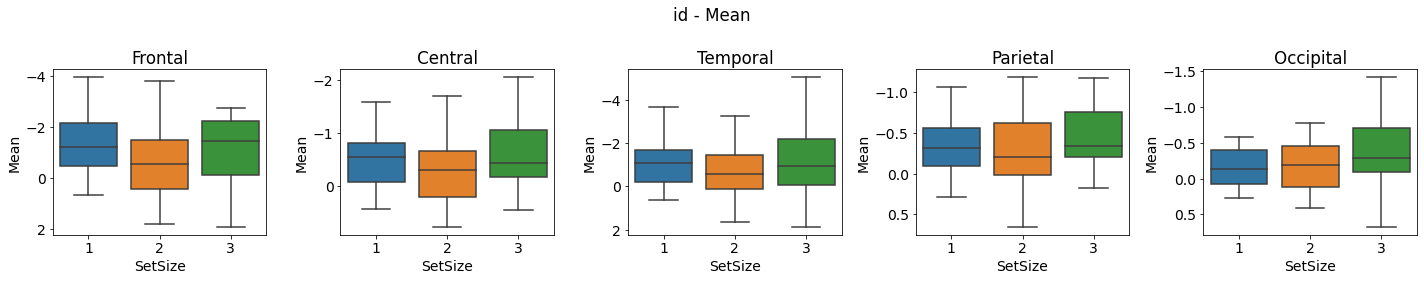

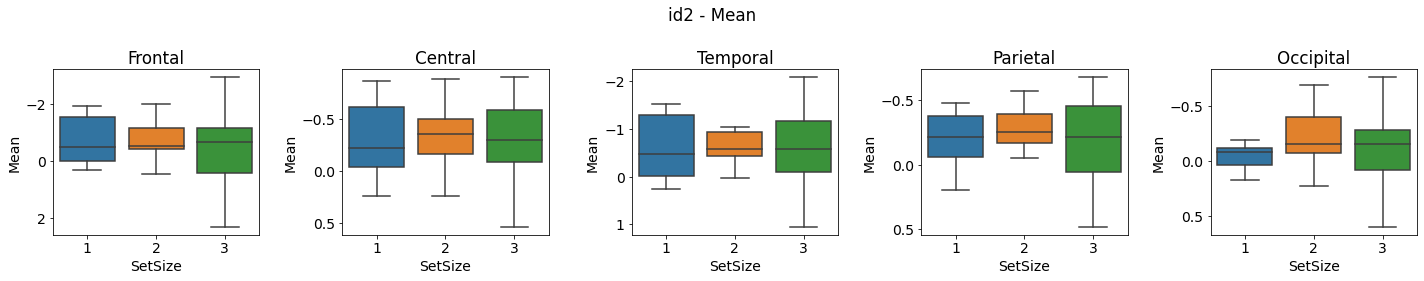

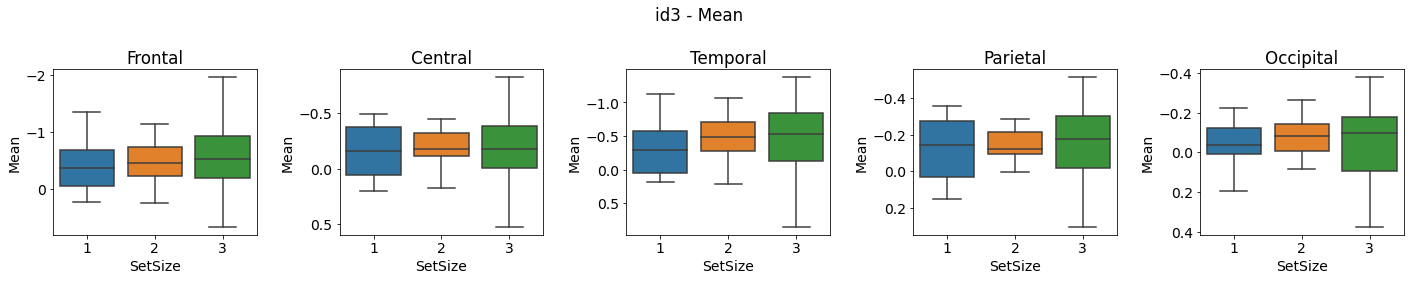

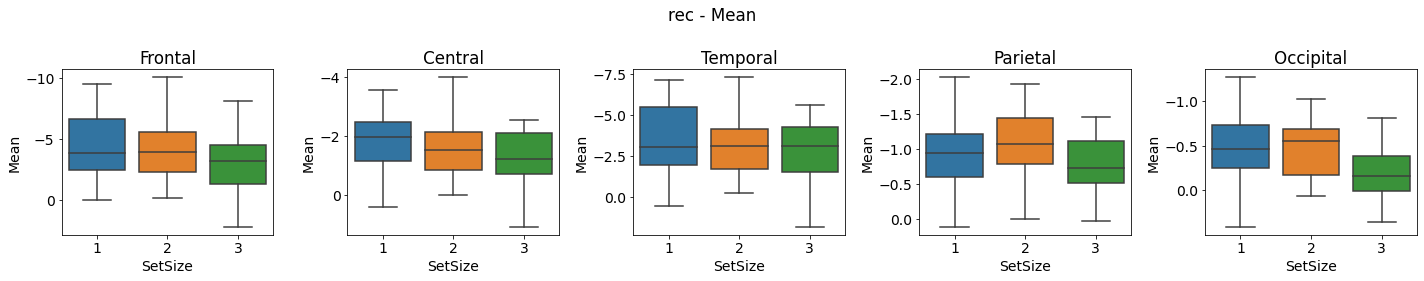

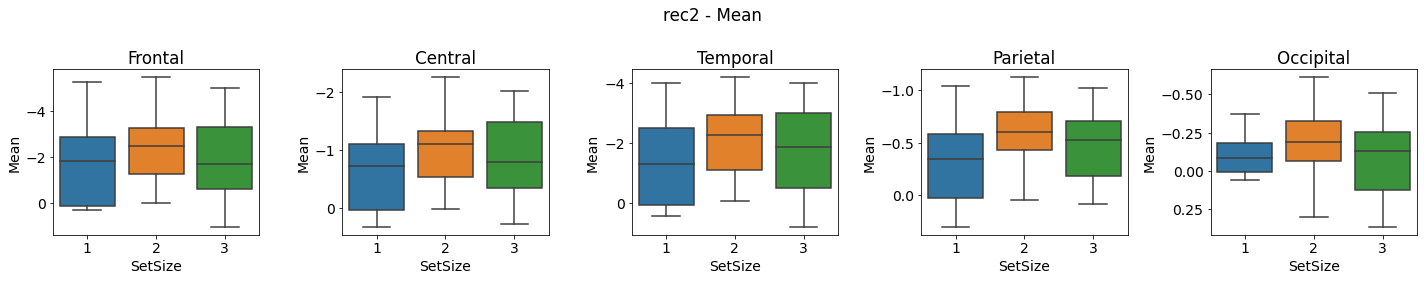

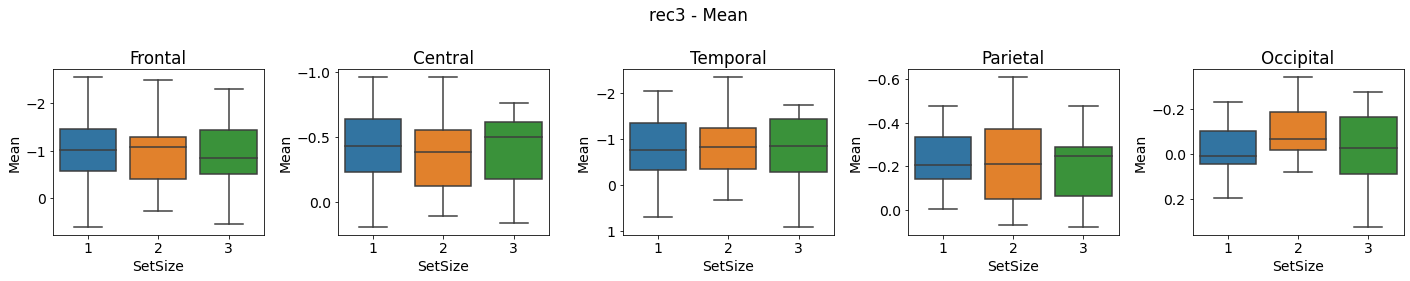

======================= Min =====================


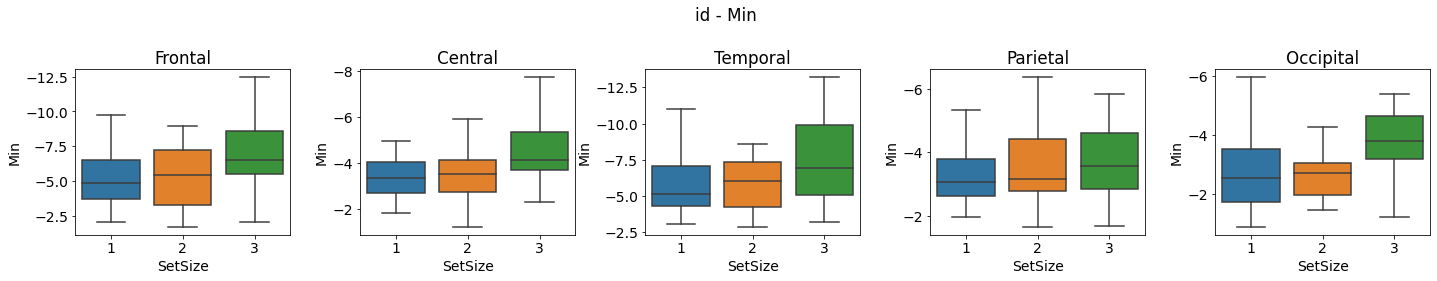

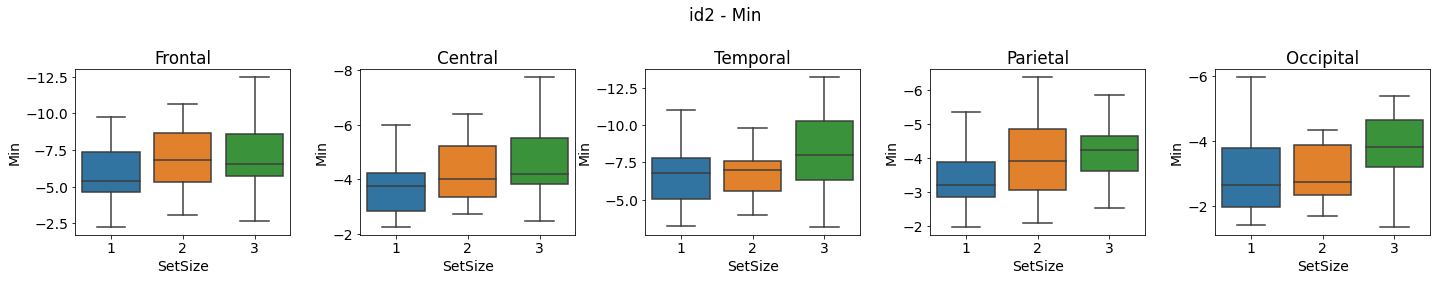

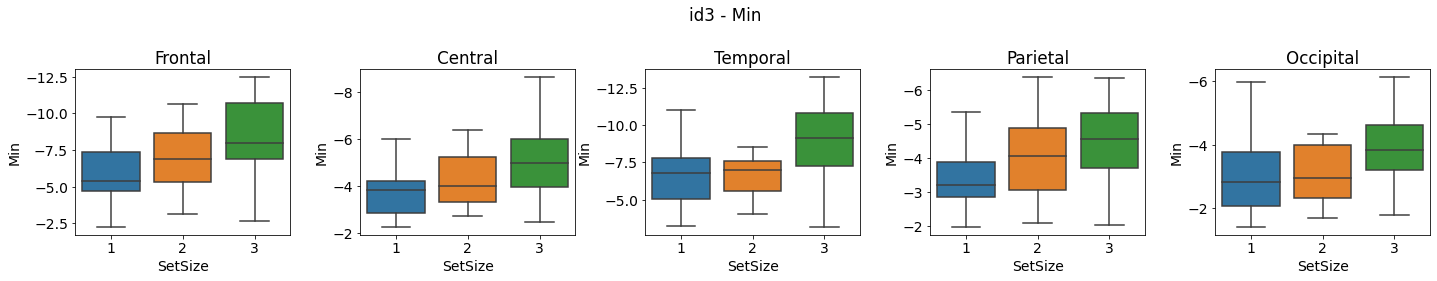

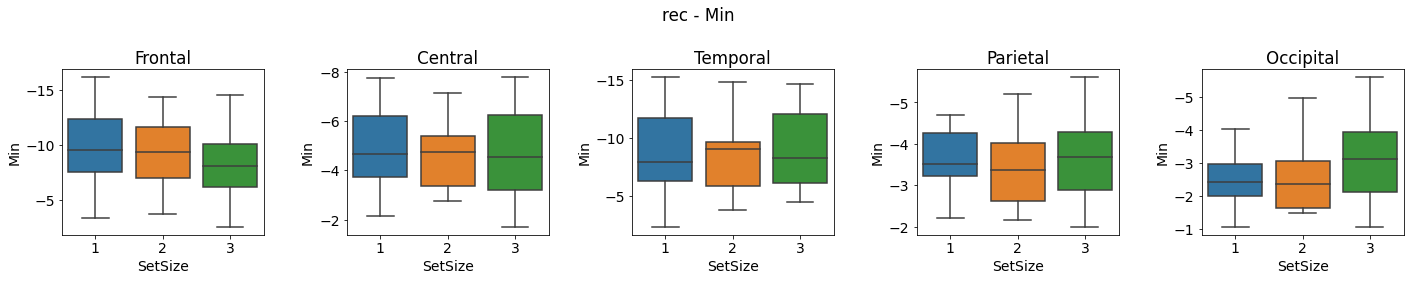

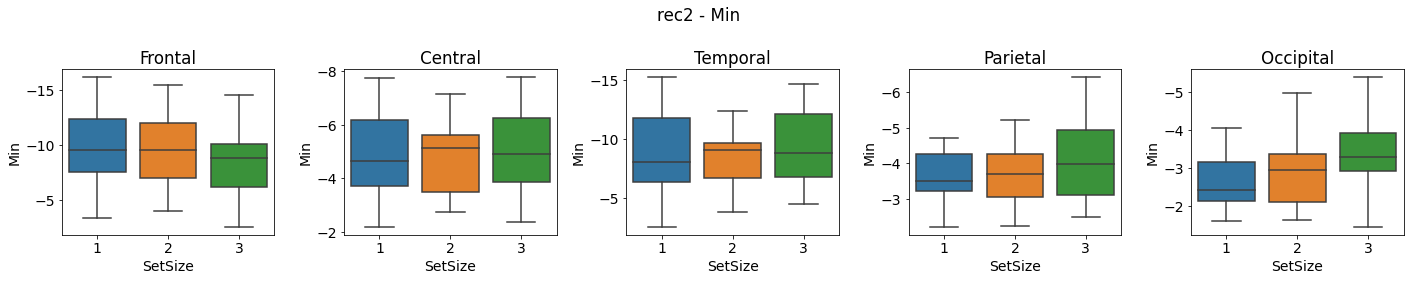

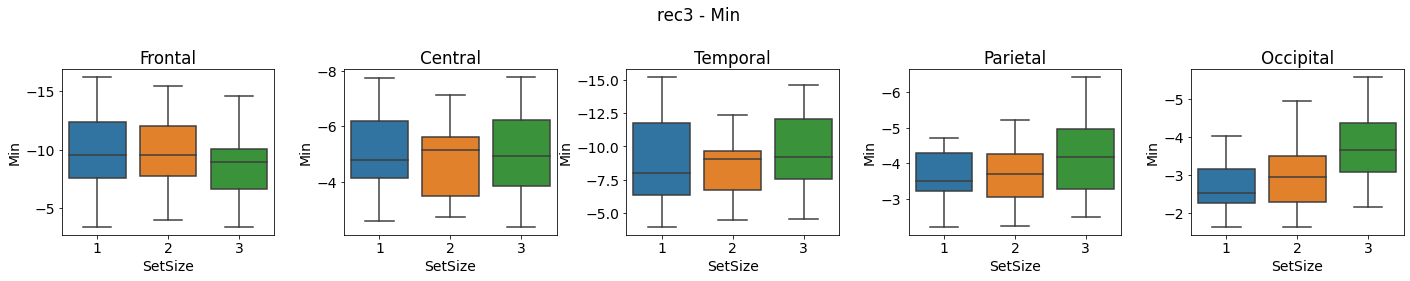

In [456]:
print('======================= Mean =====================')
for phase in stats_phases:
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(f'{phase} - Mean')
    for i, cl in enumerate(stats_clusters):
        cur_df = df_cda[(df_cda['Cluster'] == cl) & (df_cda['Phase'] == phase)]
        sns.boxplot(x="SetSize", y="Mean", data=cur_df, showfliers=False, ax=ax[i])
        ax[i].set_title(cl)
        ax[i].invert_yaxis()
        
    plt.tight_layout()
    plt.show()
    
print('======================= Min =====================')
for phase in stats_phases:
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(f'{phase} - Min')
    for i, cl in enumerate(stats_clusters):
        cur_df = df_cda[(df_cda['Cluster'] == cl) & (df_cda['Phase'] == phase)]
        sns.boxplot(x="SetSize", y="Min", data=cur_df, showfliers=False, ax=ax[i])
        ax[i].set_title(cl)
        ax[i].invert_yaxis()
        
    plt.tight_layout()
    plt.show()

In [498]:
# HAS TO BE RUN WITH ONLY THE 3 PHASES, NOT ID1,ID2,ID3, REC1, REC2, etc.

aovrm = AnovaRM(df_cda, 'Mean', 'Participant', within=['SetSize', 'Phase', 'Cluster'], aggregate_func='mean')
resaov = aovrm.fit()

print(resaov)

print('----------------------------------')

aovrm = AnovaRM(df_cda, 'Min', 'Participant', within=['SetSize', 'Phase', 'Cluster'], aggregate_func='mean')
resaov = aovrm.fit()

print(resaov)

                        Anova
                      F Value  Num DF  Den DF  Pr > F
-----------------------------------------------------
SetSize                3.5878  2.0000  34.0000 0.0386
Phase                 20.1701  2.0000  34.0000 0.0000
Cluster               32.8521  4.0000  68.0000 0.0000
SetSize:Phase          2.4621  4.0000  68.0000 0.0534
SetSize:Cluster        1.5580  8.0000 136.0000 0.1431
Phase:Cluster         18.3024  8.0000 136.0000 0.0000
SetSize:Phase:Cluster  1.6038 16.0000 272.0000 0.0673

----------------------------------
                        Anova
                      F Value   Num DF  Den DF  Pr > F
------------------------------------------------------
SetSize                 5.4742  2.0000  34.0000 0.0087
Phase                  24.7883  2.0000  34.0000 0.0000
Cluster               112.4487  4.0000  68.0000 0.0000
SetSize:Phase           2.4717  4.0000  68.0000 0.0526
SetSize:Cluster         0.7930  8.0000 136.0000 0.6097
Phase:Cluster          19.1020  8

In [470]:
anova_table_keys = [val for val in resaov.anova_table]

aov_clusters = stats_clusters.copy()
aov_clusters.append('All')
for cluster in aov_clusters:
    print(f'################### {cluster.upper()} ###################')
    print('------------------------------------------------------------')
    print('ROI \t\t F-score \t df \t DN \t p-val')
    print('------------------------------------------------------------')
    for mode in ['Mean', 'Min']:
        for phase in stats_phases:        
            if cluster == 'All':
                cur_df = df_cda[(df_cda['Phase'] == phase)]
            else:
                cur_df = df_cda[(df_cda['Phase'] == phase) & (df_cda['Cluster'] == cluster)]
            aovrm = AnovaRM(cur_df, mode, 'Participant', within=['SetSize'], aggregate_func='mean')
            resaov = aovrm.fit()

            stats_vals = [resaov.anova_table[cur_key][0] for cur_key in anova_table_keys]
            if stats_vals[3] < 0.0001:
                sig_stars = '***'
            elif stats_vals[3] < 0.001:
                sig_stars = '**'
            elif stats_vals[3] < 0.01:
                sig_stars = '*'
            else:
                sig_stars = ''
            print('{} - {}: \t {:.4f} \t {} \t {} \t {:.4} \t  {}'.format(phase, mode, stats_vals[0], int(stats_vals[1]), int(stats_vals[2]), stats_vals[3], sig_stars))
        print('\n')
    print('\n')

################### FRONTAL ###################
------------------------------------------------------------
ROI 		 F-score 	 df 	 DN 	 p-val
------------------------------------------------------------
id - Mean: 	 0.7574 	 2 	 34 	 0.4766 	  
id2 - Mean: 	 0.7158 	 2 	 34 	 0.496 	  
id3 - Mean: 	 0.6635 	 2 	 34 	 0.5216 	  
rec - Mean: 	 3.8949 	 2 	 34 	 0.02999 	  
rec2 - Mean: 	 2.6083 	 2 	 34 	 0.08834 	  
rec3 - Mean: 	 1.2009 	 2 	 34 	 0.3134 	  


id - Min: 	 3.5352 	 2 	 34 	 0.04029 	  
id2 - Min: 	 4.3588 	 2 	 34 	 0.02065 	  
id3 - Min: 	 8.2226 	 2 	 34 	 0.001222 	  *
rec - Min: 	 1.1791 	 2 	 34 	 0.3198 	  
rec2 - Min: 	 0.8819 	 2 	 34 	 0.4232 	  
rec3 - Min: 	 0.7140 	 2 	 34 	 0.4969 	  




################### CENTRAL ###################
------------------------------------------------------------
ROI 		 F-score 	 df 	 DN 	 p-val
------------------------------------------------------------
id - Mean: 	 0.2512 	 2 	 34 	 0.7793 	  
id2 - Mean: 	 0.2419 	 2 	 3

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


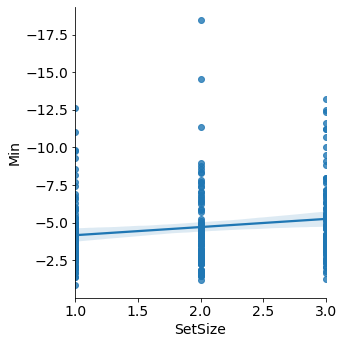

In [491]:
#cur_df = df_cda[(df_cda['Cluster'] == 'Occipital') & (df_cda['Phase'] == 'id')]
cur_df = df_cda[(df_cda['Phase'] == 'id')]
cur_df['SetSize'] = pd.to_numeric(cur_df['SetSize'])
sns.lmplot(x="SetSize", y="Min", data=cur_df)
plt.gca().invert_yaxis()
plt.tight_layout()
#plot.title(cl)

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


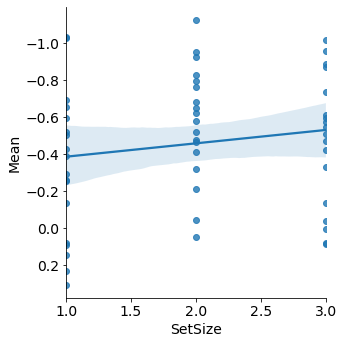

In [490]:
cur_df = df_cda[(df_cda['Cluster'] == 'Parietal') & (df_cda['Phase'] == 'rec2')]
cur_df['SetSize'] = pd.to_numeric(cur_df['SetSize'])
sns.lmplot(x="SetSize", y="Mean", data=cur_df)
plt.gca().invert_yaxis()
plt.tight_layout()
#plot.title(cl)

In [390]:
# Best Results for Recall2 - Mean || ID3 - Min   --   Whole Head.
for mode in ['Mean', 'Min']:
    for phase in stats_phases:
        print('================================================================')
        print(f'{phase} -- {mode}')
        cur_df = df_cda[(df_cda['Phase'] == phase)]
        print(scipy.stats.ttest_rel(cur_df[cur_df['SetSize'] == '1'][mode], cur_df[cur_df['SetSize'] == '3'][mode]))
        print(scipy.stats.ttest_rel(cur_df[cur_df['SetSize'] == '1'][mode], cur_df[cur_df['SetSize'] == '2'][mode]))
        print(scipy.stats.ttest_rel(cur_df[cur_df['SetSize'] == '2'][mode], cur_df[cur_df['SetSize'] == '3'][mode]))
        print('================================================================')

id -- Mean
Ttest_relResult(statistic=0.2573990390830865, pvalue=0.7974649291146876)
Ttest_relResult(statistic=-1.067461225575118, pvalue=0.28865059186882797)
Ttest_relResult(statistic=1.7271522717822458, pvalue=0.08760938830505788)
id2 -- Mean
Ttest_relResult(statistic=-0.7824599452954499, pvalue=0.43602124535935216)
Ttest_relResult(statistic=1.9918608840197798, pvalue=0.04945169137807897)
Ttest_relResult(statistic=-2.2672309653126463, pvalue=0.025798003879037582)
id3 -- Mean
Ttest_relResult(statistic=1.5317203939636765, pvalue=0.12913842571867118)
Ttest_relResult(statistic=3.618608209501794, pvalue=0.0004912585328386644)
Ttest_relResult(statistic=-0.4451653925551104, pvalue=0.6572810967771434)
recall -- Mean
Ttest_relResult(statistic=-3.7405441669280624, pvalue=0.000324546036407592)
Ttest_relResult(statistic=-2.3068407706167813, pvalue=0.023384987036859164)
Ttest_relResult(statistic=-3.0694210594286226, pvalue=0.002843048767284828)
recall2 -- Mean
Ttest_relResult(statistic=2.255674084

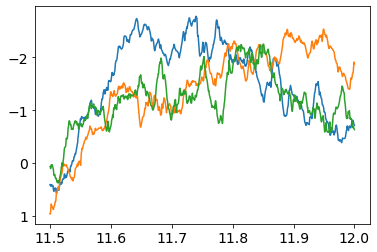

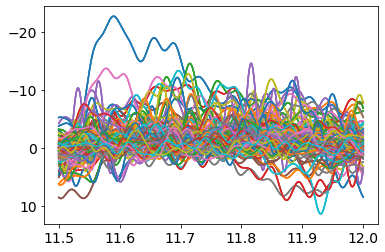

In [419]:
cda_signal = dict()

# TODO: Retry with side? Perhaps there is an effect! (as seen on lateralized activity)
phase = 'recall'
for setsize in stats_setsizes:
    cda_signal[setsize] = []
    for cluster in stats_clusters: # ['Frontal']:
        cda_left = None
        cda_right = None
        for participant in participant_list:
            if participant == 'F26F2.bdf' or participant == 'F5M1.bdf':
                continue
            try:
                cda_left = CDA_ss_all[participant][cluster][setsize]['left']
            except:
                print(f'Skipping...{participant}-{cluster}-{setsize}-left')
            try:
                cda_right = CDA_ss_all[participant][cluster][setsize]['right']
            except:
                print(f'Skipping...{participant}-{cluster}-{setsize}-right')

            if cda_left is not None and cda_right is not None:
                cur_cda = ((cda_right + cda_left)/2) * 1e6
                cur_cda = cur_cda[(times >= stats_time_windows[phase][0]) & (times <= stats_time_windows[phase][1])]
                cda_signal[setsize].append(cur_cda)

for size in conds:
    plt.plot(times[(times >= stats_time_windows[phase][0]) & (times <= stats_time_windows[phase][1])], np.median(np.stack(cda_signal[size]), 0))
    
plt.gca().invert_yaxis()
plt.show()

for size in conds:
    for cur_signal in cda_signal['3']:
        plt.plot(times[(times >= stats_time_windows[phase][0]) & (times <= stats_time_windows[phase][1])], cur_signal)
    
plt.gca().invert_yaxis()
plt.show()

#for size in conds:
#    plt.plot(times[times_windows_cda['id']], np.median(np.stack(cda_signal[size]), 0)[times_windows_cda['id']])
    
#plt.gca().invert_yaxis()
#plt.show()

In [422]:
a = [np.mean(cur_signal) for cur_signal in cda_signal['2']]
b = [np.mean(cur_signal) for cur_signal in cda_signal['1']]
scipy.stats.ttest_rel(a, b)

Ttest_relResult(statistic=2.3068407706167813, pvalue=0.023384987036859164)

# Quickies... To be deleted.

In [22]:
df.loc[(df['SetSize']=="1") & (df['Phase']=="id") & (df['FBand']=="delta") & (df['Participant']=="F12F2"), 'Power'] = 50

In [10]:
import re

string = "123AAAMississippiZZZ123"

try:
    found = re.search('AAA(.+?)ZZZ', string).group(1)
    print(found)
except AttributeError:
    pass

Mississippi
